In [4]:
# River Recovery Modeling Script Using Year-Specific DEMs (Normalized Index)

import rasterio
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude
import os

# -------------------- INPUT RASTER PATHS PER YEAR --------------------
data_by_year = {
    1990: {
        "veg": r"H:\Major_Project\Work\Vegetation_Class\1990_Brahmaputra\Classified_1990_masked.tif",
        "ndvi": r"H:\Major_Project\Work\NDVI\Actual\NDVI_1990_Brahmaputra.tif",
        "water": r"H:\Major_Project\Work\lpicodes\Brahmaputra_Input\BRAHMAPUTRA_1990.tif",
        "dem": r"H:\Major_Project\Work\DEM\srtm_dem_brahmaputra_new.tif"
    },
    2000: {
        "veg": r"H:\Major_Project\Work\Vegetation_Class\2000_Brahmaputra\Classified_2000_masked.tif",
        "ndvi": r"H:\Major_Project\Work\NDVI\Actual\NDVI_2000_Brahmaputra.tif",
        "water": r"H:\Major_Project\Work\lpicodes\Brahmaputra_Input\BRAHMAPUTRA_2000.tif",
        "dem": r"H:\Major_Project\Work\DEM\srtm_dem_brahmaputra_new.tif"
    },
    2010: {
        "veg": r"H:\Major_Project\Work\Vegetation_Class\2010_Brahmaputra\Classified_2010_masked.tif",
        "ndvi": r"H:\Major_Project\Work\NDVI\Actual\NDVI_2010_Brahmaputra.tif",
        "water": r"H:\Major_Project\Work\lpicodes\Brahmaputra_Input\BRAHMAPUTRA_2010.tif",
        "dem": r"H:\Major_Project\Work\DEM\aster_dem_brahmaputra_new.tif"
    },
    2020: {
        "veg": r"H:\Major_Project\Work\Vegetation_Class\2020_Brahmaputra\Classified_2020_masked.tif",
        "ndvi": r"H:\Major_Project\Work\NDVI\Actual\NDVI_2020_Brahmaputra.tif",
        "water": r"H:\Major_Project\Work\lpicodes\Brahmaputra_Input\BRAHMAPUTRA_2020.tif",
        "dem": r"H:\Major_Project\Work\DEM\nasadem_brahmaputra_new.tif"
    },
    2024: {
        "veg": r"H:\Major_Project\Work\Vegetation_Class\2024_Brahmaputra\Classified_2024_masked.tif",
        "ndvi": r"H:\Major_Project\Work\NDVI\Actual\NDVI_2024_Brahmaputra.tif",
        "water": r"H:\Major_Project\Work\lpicodes\Brahmaputra_Input\BRAHMAPUTRA_2020.tif",
        "dem": r"H:\Major_Project\Work\DEM\nasadem_brahmaputra_new.tif"
    }
}

output_dir = r"H:\Major_Project\Work\Recovery_Index_Training\Output_1"
os.makedirs(output_dir, exist_ok=True)

# -------------------- FUNCTIONS --------------------
def save_raster(path, array, profile):
    profile.update(dtype='float32', count=1, nodata=np.nan)
    with rasterio.open(path, 'w', **profile) as dst:
        dst.write(array.astype('float32'), 1)

def read_and_align(path, reference_meta):
    with rasterio.open(path) as src:
        if (src.width != reference_meta['width'] or
            src.height != reference_meta['height'] or
            src.transform != reference_meta['transform']):
            data = src.read(
                out_shape=(1, reference_meta['height'], reference_meta['width']),
                resampling=rasterio.enums.Resampling.nearest
            )[0]
        else:
            data = src.read(1)
    return data

# -------------------- PROCESS YEARS --------------------
for year, paths in data_by_year.items():
    print(f"\n🌍 Processing Year: {year}")

    # Load DEM
    with rasterio.open(paths["dem"]) as src:
        dem = src.read(1).astype('float32')
        dem_profile = src.profile
        dem[dem == dem_profile['nodata']] = np.nan

    # Z-score and slope
    mean = np.nanmean(dem)
    std = np.nanstd(dem)
    z_score = (dem - mean) / std
    slope = gaussian_gradient_magnitude(dem, sigma=1)

    save_raster(os.path.join(output_dir, f"z_score_{year}.tif"), z_score, dem_profile)
    save_raster(os.path.join(output_dir, f"slope_{year}.tif"), slope, dem_profile)

    # Load and align rasters
    veg = read_and_align(paths["veg"], dem_profile)
    water_prob = read_and_align(paths["water"], dem_profile).astype('float32')
    ndvi = read_and_align(paths["ndvi"], dem_profile).astype('float32')

    # Reclassify vegetation
    veg_reclass = np.where(veg == 1, 3,
                   np.where(veg == 2, 2,
                   np.where(veg == 3, 1,
                   np.nan)))

    dry_exposure = 1 - water_prob

    valid_mask = ~np.isnan(veg_reclass)
    woody_mask = (veg_reclass == 3).astype('float32')

    # Compute raw recovery score
    raw_index = np.full_like(dem, np.nan, dtype='float32')
    raw_index[valid_mask] = (
        woody_mask[valid_mask] * 0.50 +
        z_score[valid_mask] * 0.25 +
        dry_exposure[valid_mask] * 0.25
    )

    # Normalize recovery index to 0–1
    min_val = np.nanmin(raw_index)
    max_val = np.nanmax(raw_index)
    recovery_index = (raw_index - min_val) / (max_val - min_val)

    # Save all outputs
    save_raster(os.path.join(output_dir, f"veg_reclass_{year}.tif"), veg_reclass, dem_profile)
    save_raster(os.path.join(output_dir, f"dry_exposure_{year}.tif"), dry_exposure, dem_profile)
    save_raster(os.path.join(output_dir, f"ndvi_{year}.tif"), ndvi, dem_profile)
    save_raster(os.path.join(output_dir, f"recovery_index_{year}.tif"), recovery_index, dem_profile)

    print(f"    ✅ Saved recovery_index_{year}.tif")

print("\n🎉 All years processed with their respective DEMs and normalized recovery index!")




🌍 Processing Year: 1990
    ✅ Saved recovery_index_1990.tif

🌍 Processing Year: 2000
    ✅ Saved recovery_index_2000.tif

🌍 Processing Year: 2010
    ✅ Saved recovery_index_2010.tif

🌍 Processing Year: 2020
    ✅ Saved recovery_index_2020.tif

🌍 Processing Year: 2024
    ✅ Saved recovery_index_2024.tif

🎉 All years processed with their respective DEMs and normalized recovery index!


In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

# Set directory where recovery index rasters are saved
recovery_dir = r"H:\Major_Project\Work\Recovery_Index_Training\Output_1"

# Define years you want to visualize
years = [1990, 2000, 2010, 2020, 2024]
change_2024_1990 = recovery_maps[4] - recovery_maps[0]

# Load all recovery rasters
recovery_maps = []
for year in years:
    path = os.path.join(recovery_dir, f"recovery_index_{year}.tif")
    with rasterio.open(path) as src:
        recovery = src.read(1)
        recovery[recovery == src.nodata] = np.nan
        recovery_maps.append(recovery)

# Plot all maps side by side
fig, axs = plt.subplots(1, len(years), figsize=(20, 5), constrained_layout=True)
for i, year in enumerate(years):
    im = axs[i].imshow(recovery_maps[i], cmap='YlGn', vmin=0, vmax=1)
    axs[i].set_title(f"Recovery {year}")
    axs[i].axis('off')

cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Recovery Index (0–1)")
plt.tight_layout()
plt.show()
plt.savefig(r"H:\Major_Project\Work\Recovery_Index_Training\recovery_maps_all_years.png", dpi=300)


ValueError: operands could not be broadcast together with shapes (2160,8693) (2161,8694) 

In [3]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

def read_and_resample(path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
        ref_transform = ref.transform
        ref_crs = ref.crs

    with rasterio.open(path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.nearest
        )[0]
    return data

# Paths
ref_path = r"H:\Major_Project\Work\Recovery_Index_Training\Output_1\recovery_index_1990.tif"
path_2024 = r"H:\Major_Project\Work\Recovery_Index_Training\Output_1\recovery_index_2024.tif"

# Read both rasters (2024 is resampled to 1990)
ri_1990 = read_and_resample(ref_path, ref_path)
ri_2024 = read_and_resample(path_2024, ref_path)

# Calculate change
recovery_change = ri_2024 - ri_1990

# Save change raster
output_change_path = r"H:\Major_Project\Work\Recovery_Index_Training\Output_1\recovery_change_2024_1990.tif"
with rasterio.open(ref_path) as src:
    profile = src.profile
profile.update(dtype='float32', count=1, nodata=np.nan)

with rasterio.open(output_change_path, 'w', **profile) as dst:
    dst.write(recovery_change.astype('float32'), 1)

print("✅ Change map saved:", output_change_path)


✅ Change map saved: H:\Major_Project\Work\Recovery_Index_Training\Output_1\recovery_change_2024_1990.tif


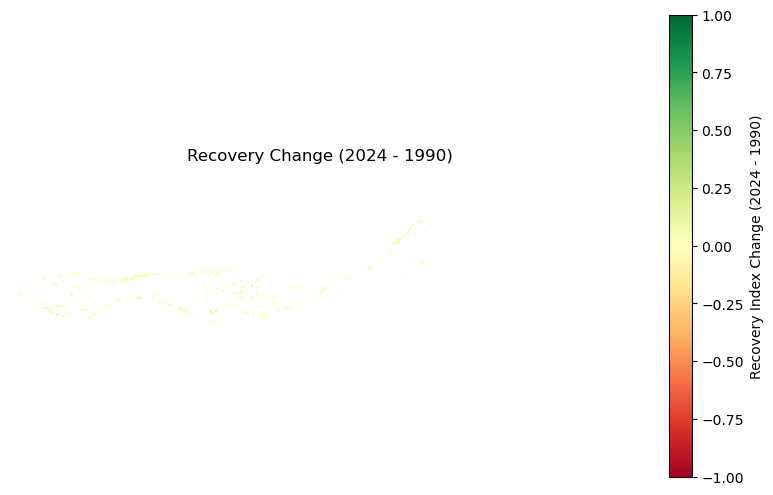

🗂️ Classified change map saved.


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(recovery_change, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='Recovery Index Change (2024 - 1990)')
plt.title('Recovery Change (2024 - 1990)')
plt.axis('off')
plt.show()

classified = np.where(recovery_change > 0.2, 1, 
              np.where(recovery_change < -0.2, -1, 0))

# 1 = improvement, 0 = no change, -1 = decline

classified_path = r"H:\Major_Project\Work\Recovery_Index_Training\Output_1\recovery_classified_change.tif"
with rasterio.open(classified_path, 'w', **profile) as dst:
    dst.write(classified.astype('int16'), 1)
print("🗂️ Classified change map saved.")
